In [113]:

%load_ext blackcellmagic

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from functools import reduce
from utils.models import weak_model_factory, no_rfx_model_factory
from utils.regression_models import regression_model_factory
from utils.tools import generate_data, load_obj, summarize_posterior, summarize_ppc

import matplotlib.pyplot as plt
%matplotlib inline


The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df = pd.read_csv('data/apixiban_regression_data.csv')

yobs = df.Concentration_scaled.values
subject_ids = pd.Categorical(df.Subject).codes 

times = df.Time.values


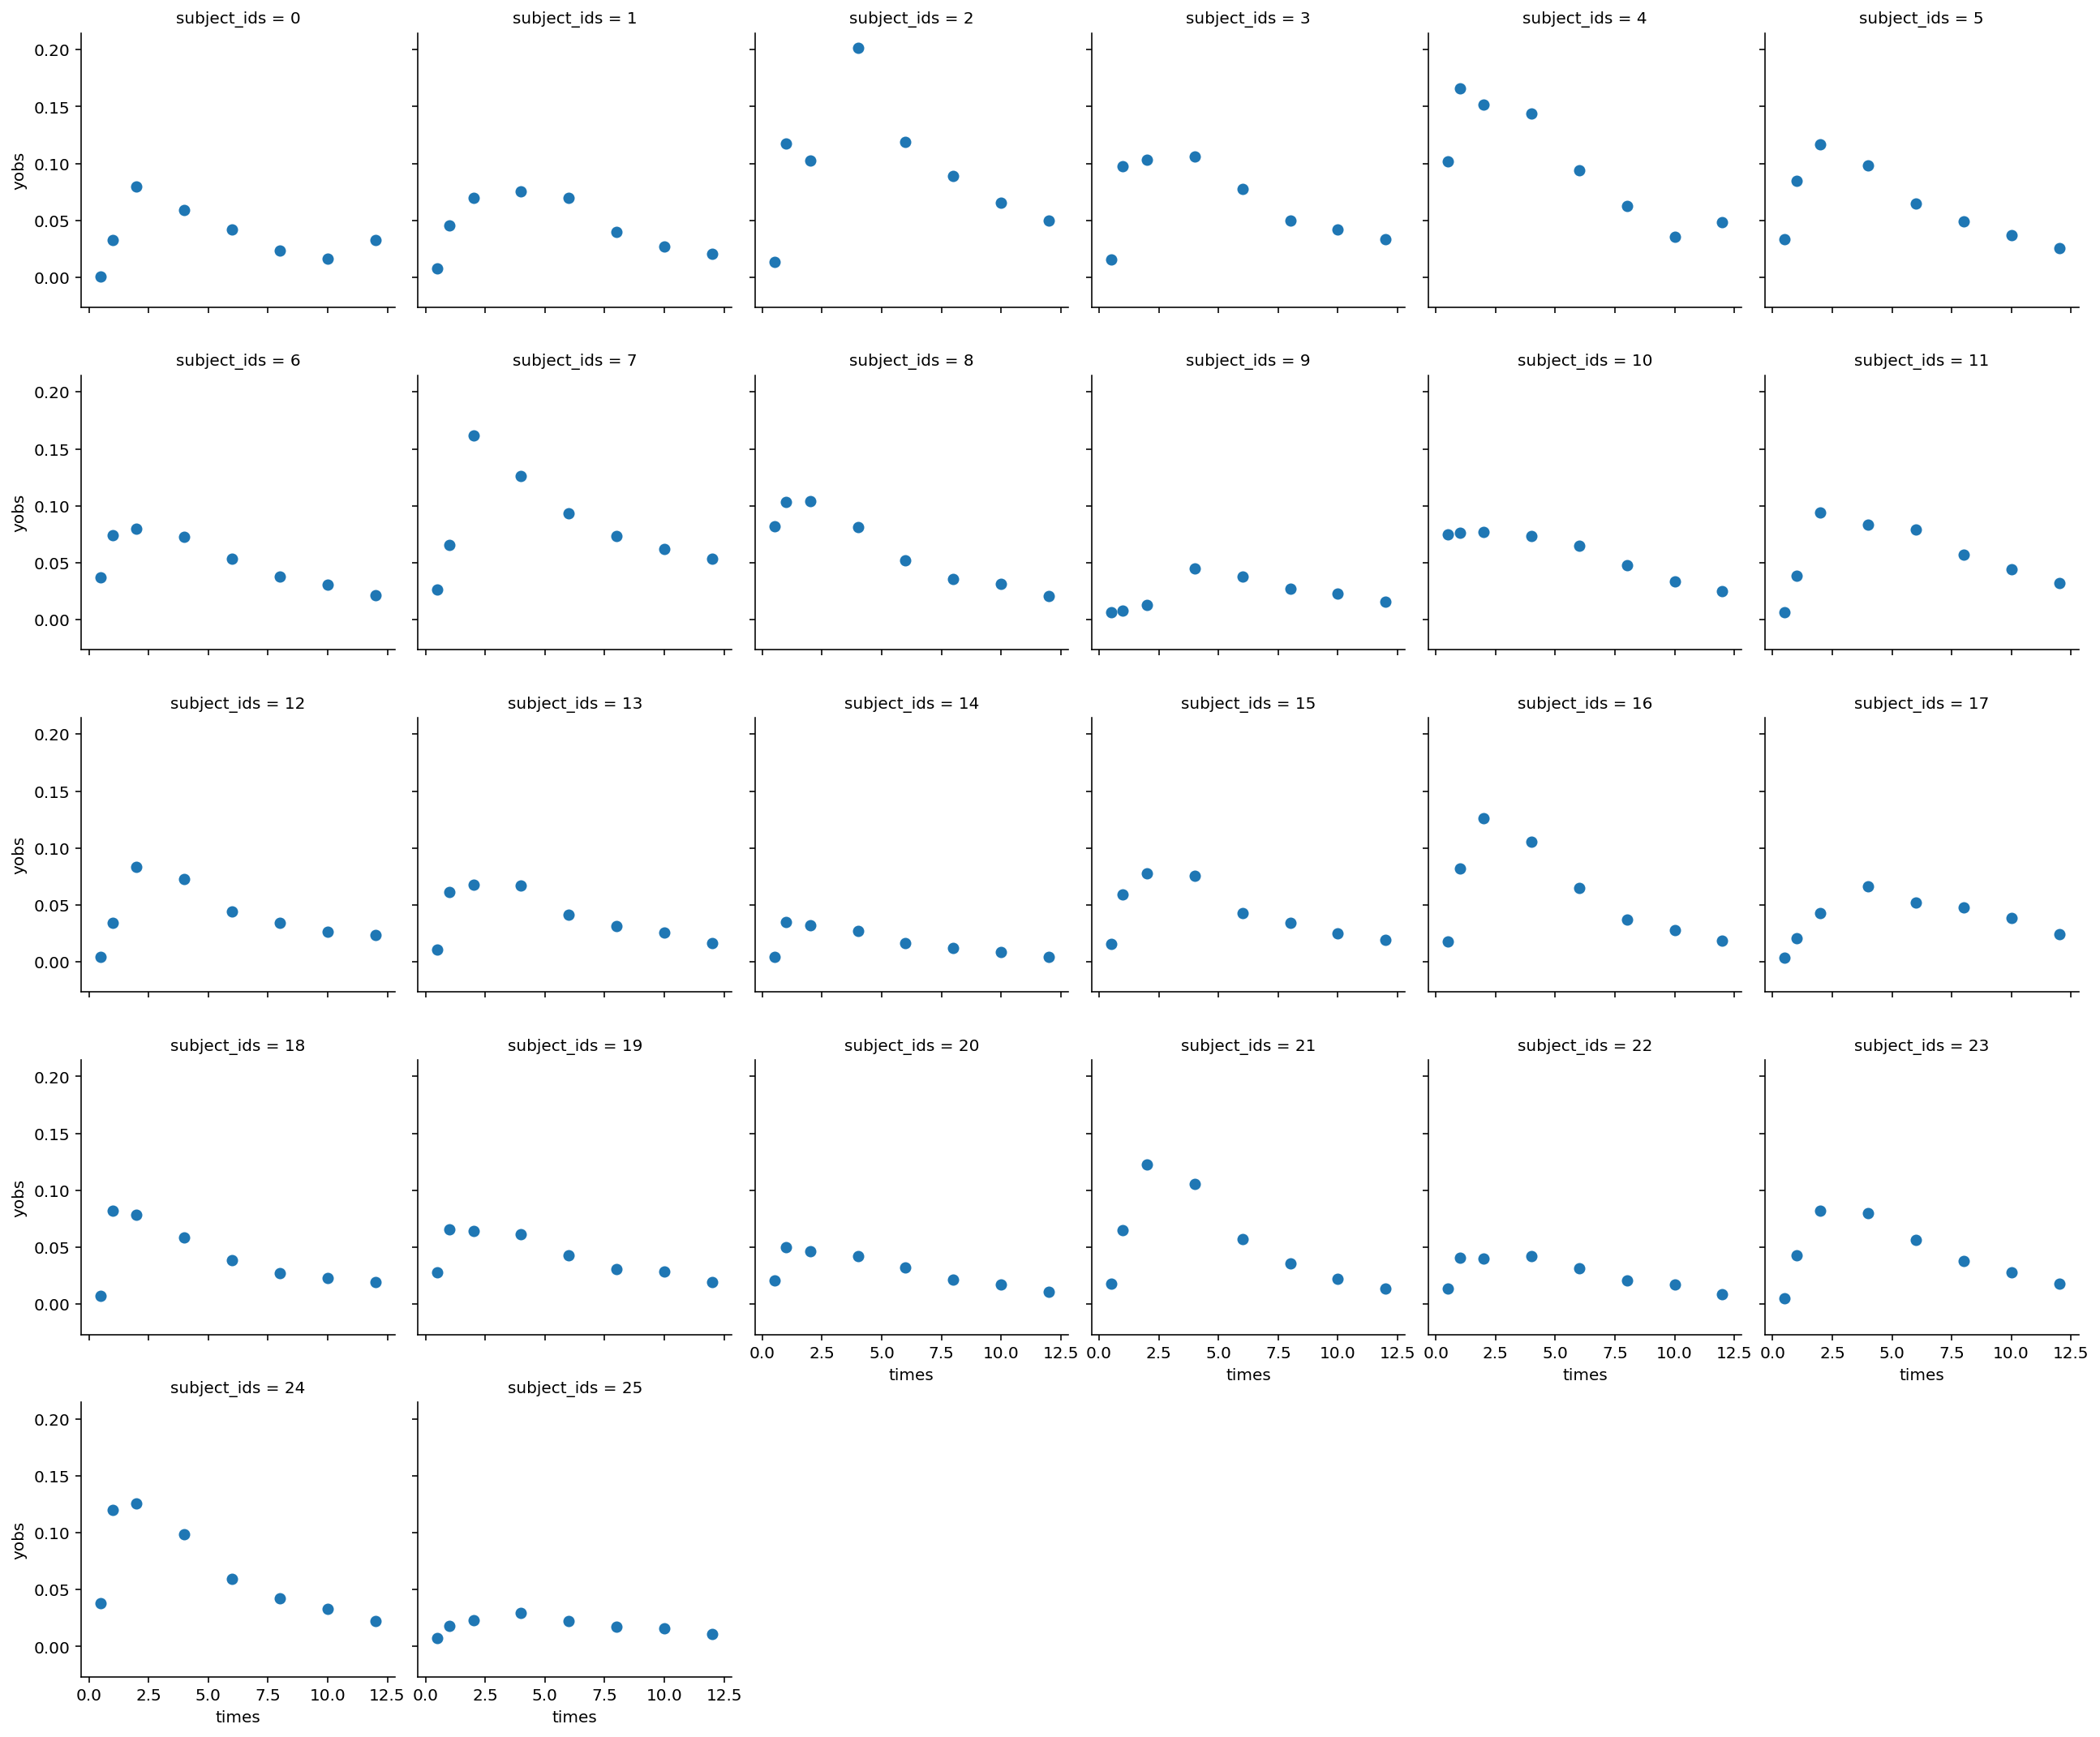

In [6]:

df = pd.DataFrame({'yobs':yobs,
                   'times':times,
                   'subject_ids':subject_ids})

g = sns.FacetGrid(data = df.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')


# Regression Models

In [8]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data/apixiban_regression_data.csv')

yobs = df.Concentration_scaled.values
subject_ids = pd.Categorical(df.Subject).codes 

times = df.Time.values

covars = df.drop_duplicates("Subject").loc[:,['Sex', 'Creatinine', 'Age']]
covars['Sex'] = covars.Sex.apply(lambda x: 1 if x=='Male' else 0)


X = covars.values
X[:,1:] = StandardScaler().fit_transform(X[:,1:])

X

array([[ 1.        ,  1.46290169, -1.66050831],
       [ 0.        ,  2.19551541,  0.27920051],
       [ 0.        , -0.89774253, -1.57233973],
       [ 0.        , -0.40933338, -0.77882248],
       [ 0.        , -0.16512881,  1.07271776],
       [ 0.        , -0.49073491, -1.04332823],
       [ 1.        ,  2.19551541, -0.51431673],
       [ 0.        , -0.24653033, -0.33797957],
       [ 0.        , -0.24653033,  0.72004343],
       [ 1.        , -0.24653033, -0.07347382],
       [ 0.        , -0.57213643,  0.45553768],
       [ 0.        , -0.81634101, -0.60248532],
       [ 0.        , -0.65353796, -0.86699106],
       [ 1.        , -0.97914405,  0.72004343],
       [ 1.        ,  0.32328034, -0.33797957],
       [ 0.        ,  0.        ,  0.89638059],
       [ 0.        , -1.4675532 ,  1.24905492],
       [ 0.        , -1.4675532 , -0.6906539 ],
       [ 0.        ,  0.73028796,  1.16088634],
       [ 1.        , -1.4675532 , -1.57233973],
       [ 1.        ,  0.81168949,  1.778

In [124]:
from utils.regression_models import regression_model_factory
with regression_model_factory(yobs, X, times, subject_ids, use_delay = True):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample()
    posterior_predictive = pm.sample_posterior_predictive(trace)

    model = az.from_pymc3(prior = prior_predictive, trace = trace, posterior_predictive = posterior_predictive)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, delays, delay_kappa, delay_mu, s_ka, z_ka, betas_ka, alpha, s_ke, z_ke, betas_ke, log_ke, s_CL, z_CL, betas_CL, log_CL]
100%|██████████| 1000/1000 [00:02<00:00, 391.21it/s]


# Model Priors

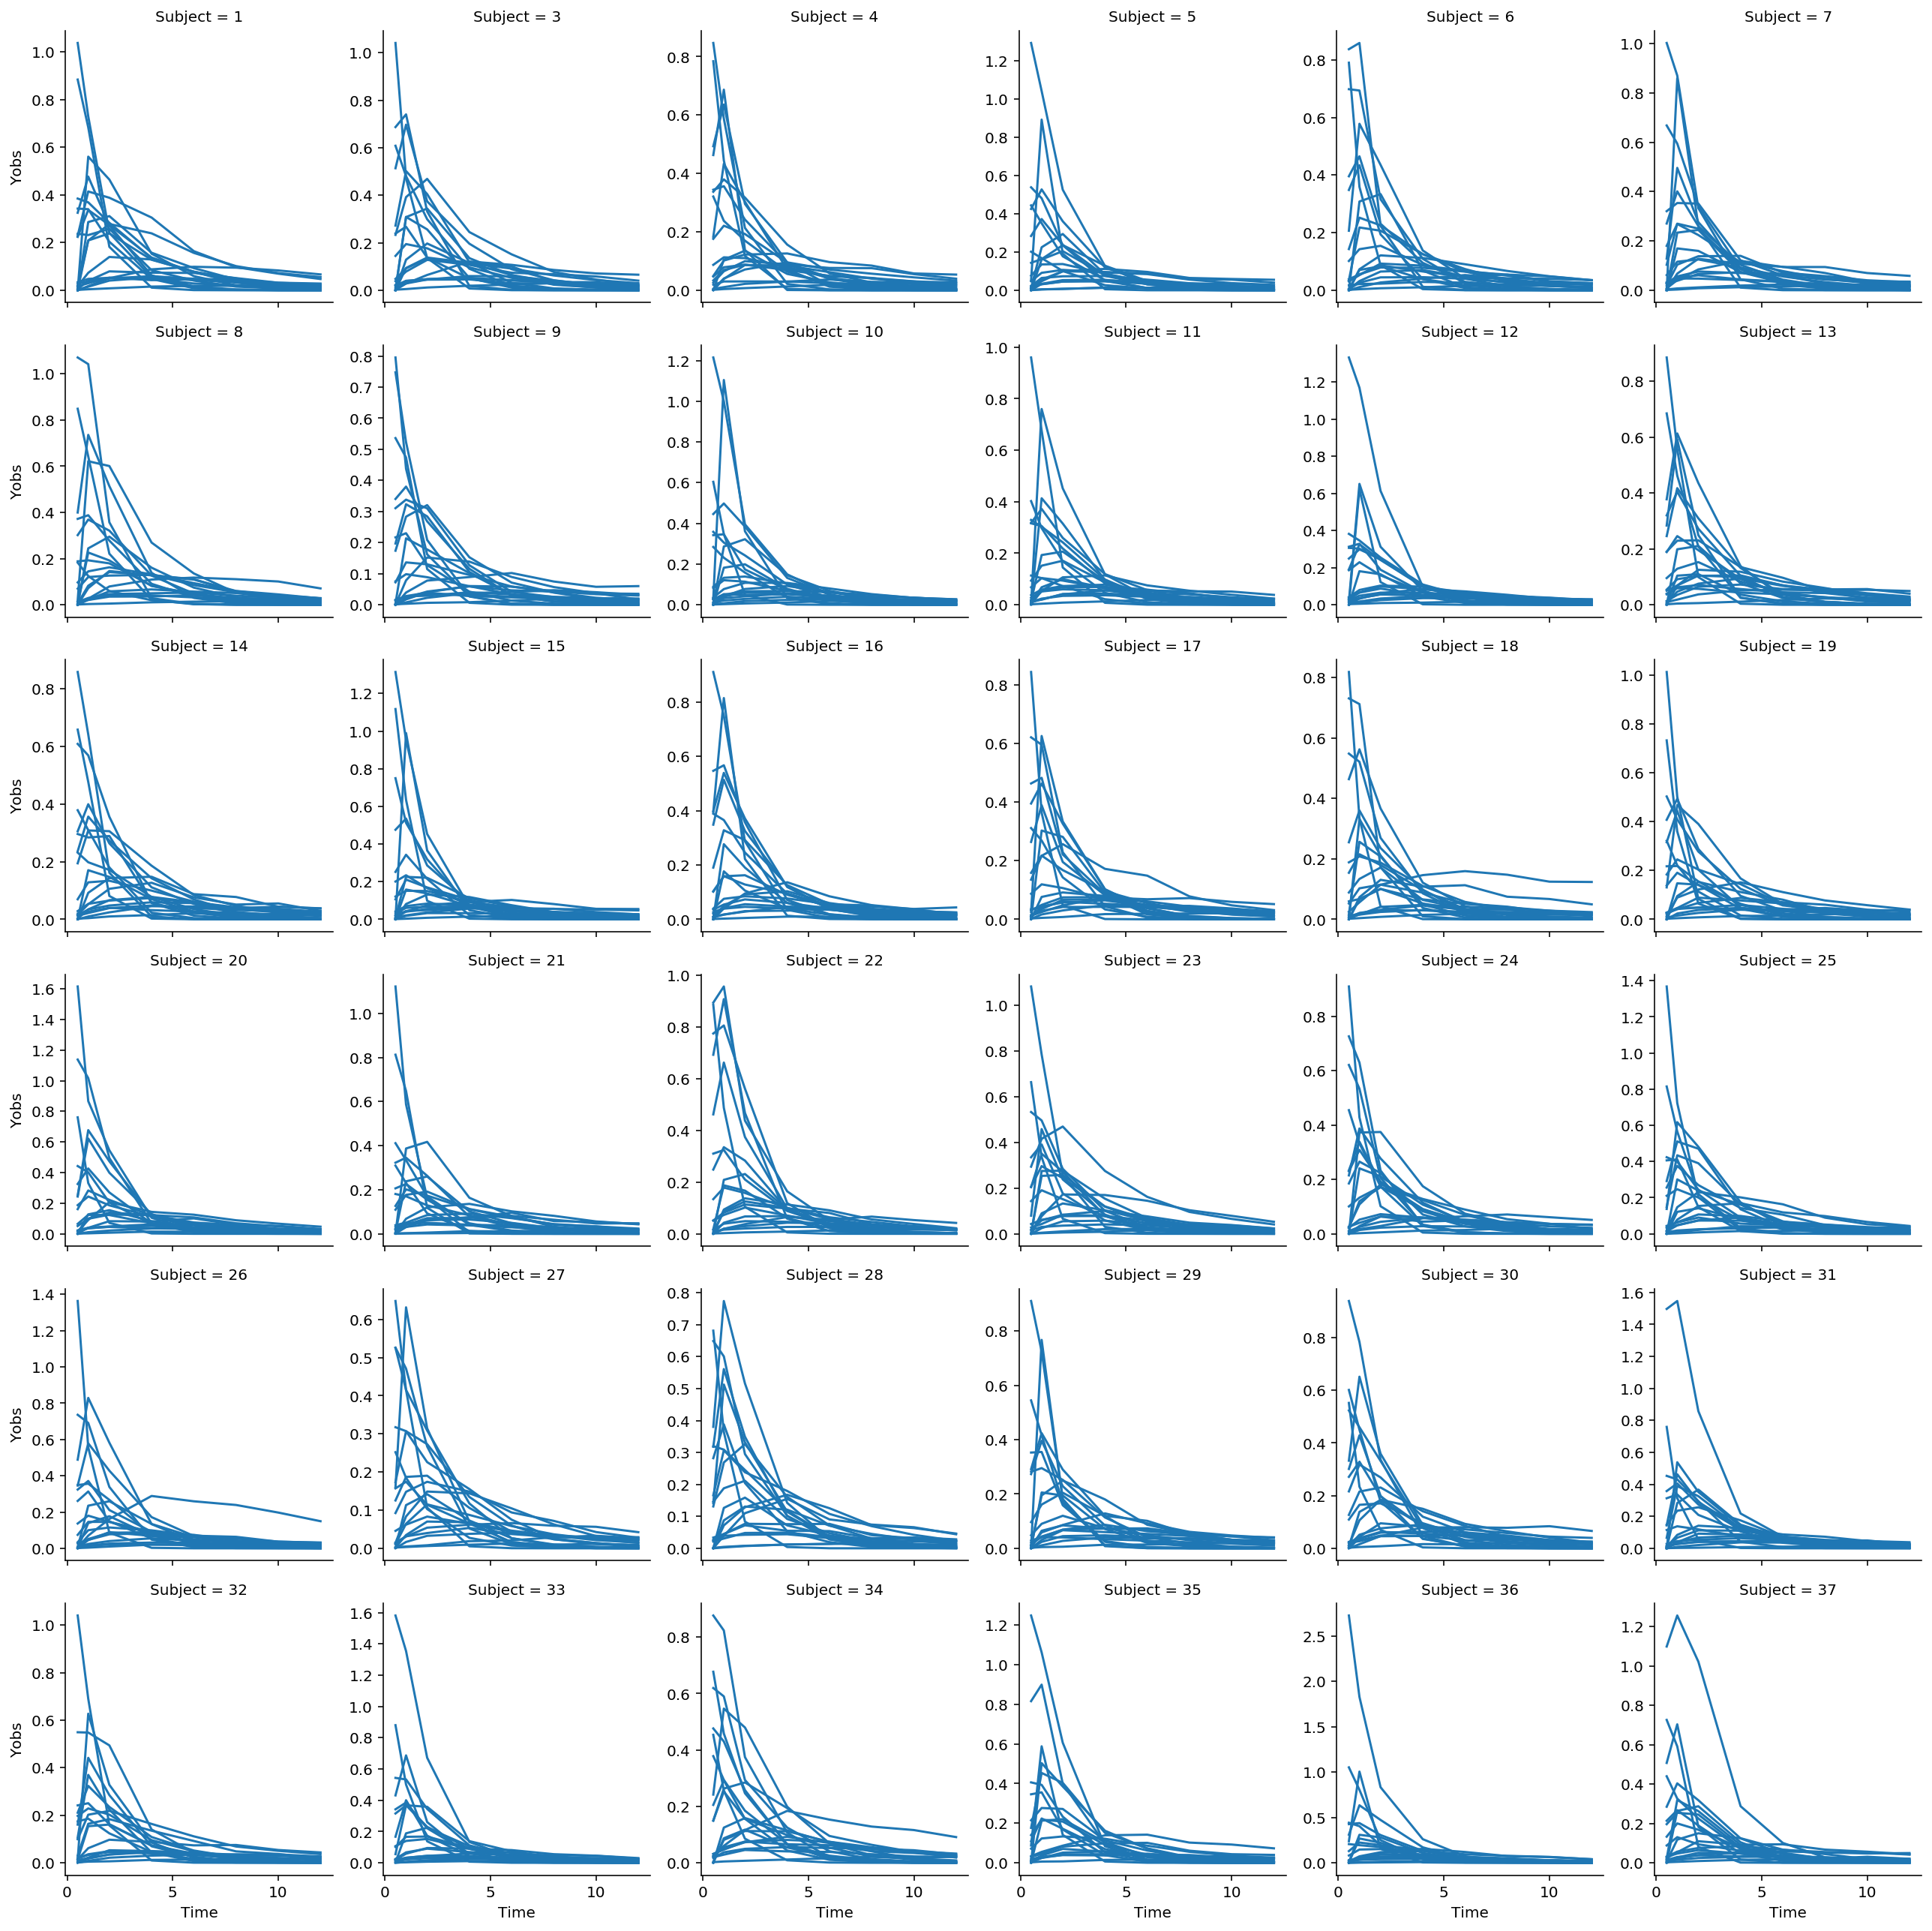

In [125]:
model_prior = model.prior.Yobs.to_dataframe().query('draw<20')
dfsub = df.loc[:,['Time','Subject']]
replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='Yobs_dim_0').reset_index('draw')

g = sns.FacetGrid(data = replicates, col='Subject', col_wrap=6, sharey = False)
g.map_dataframe(sns.lineplot,'Time','Yobs',estimator=None, units='draw')

# Model Fit

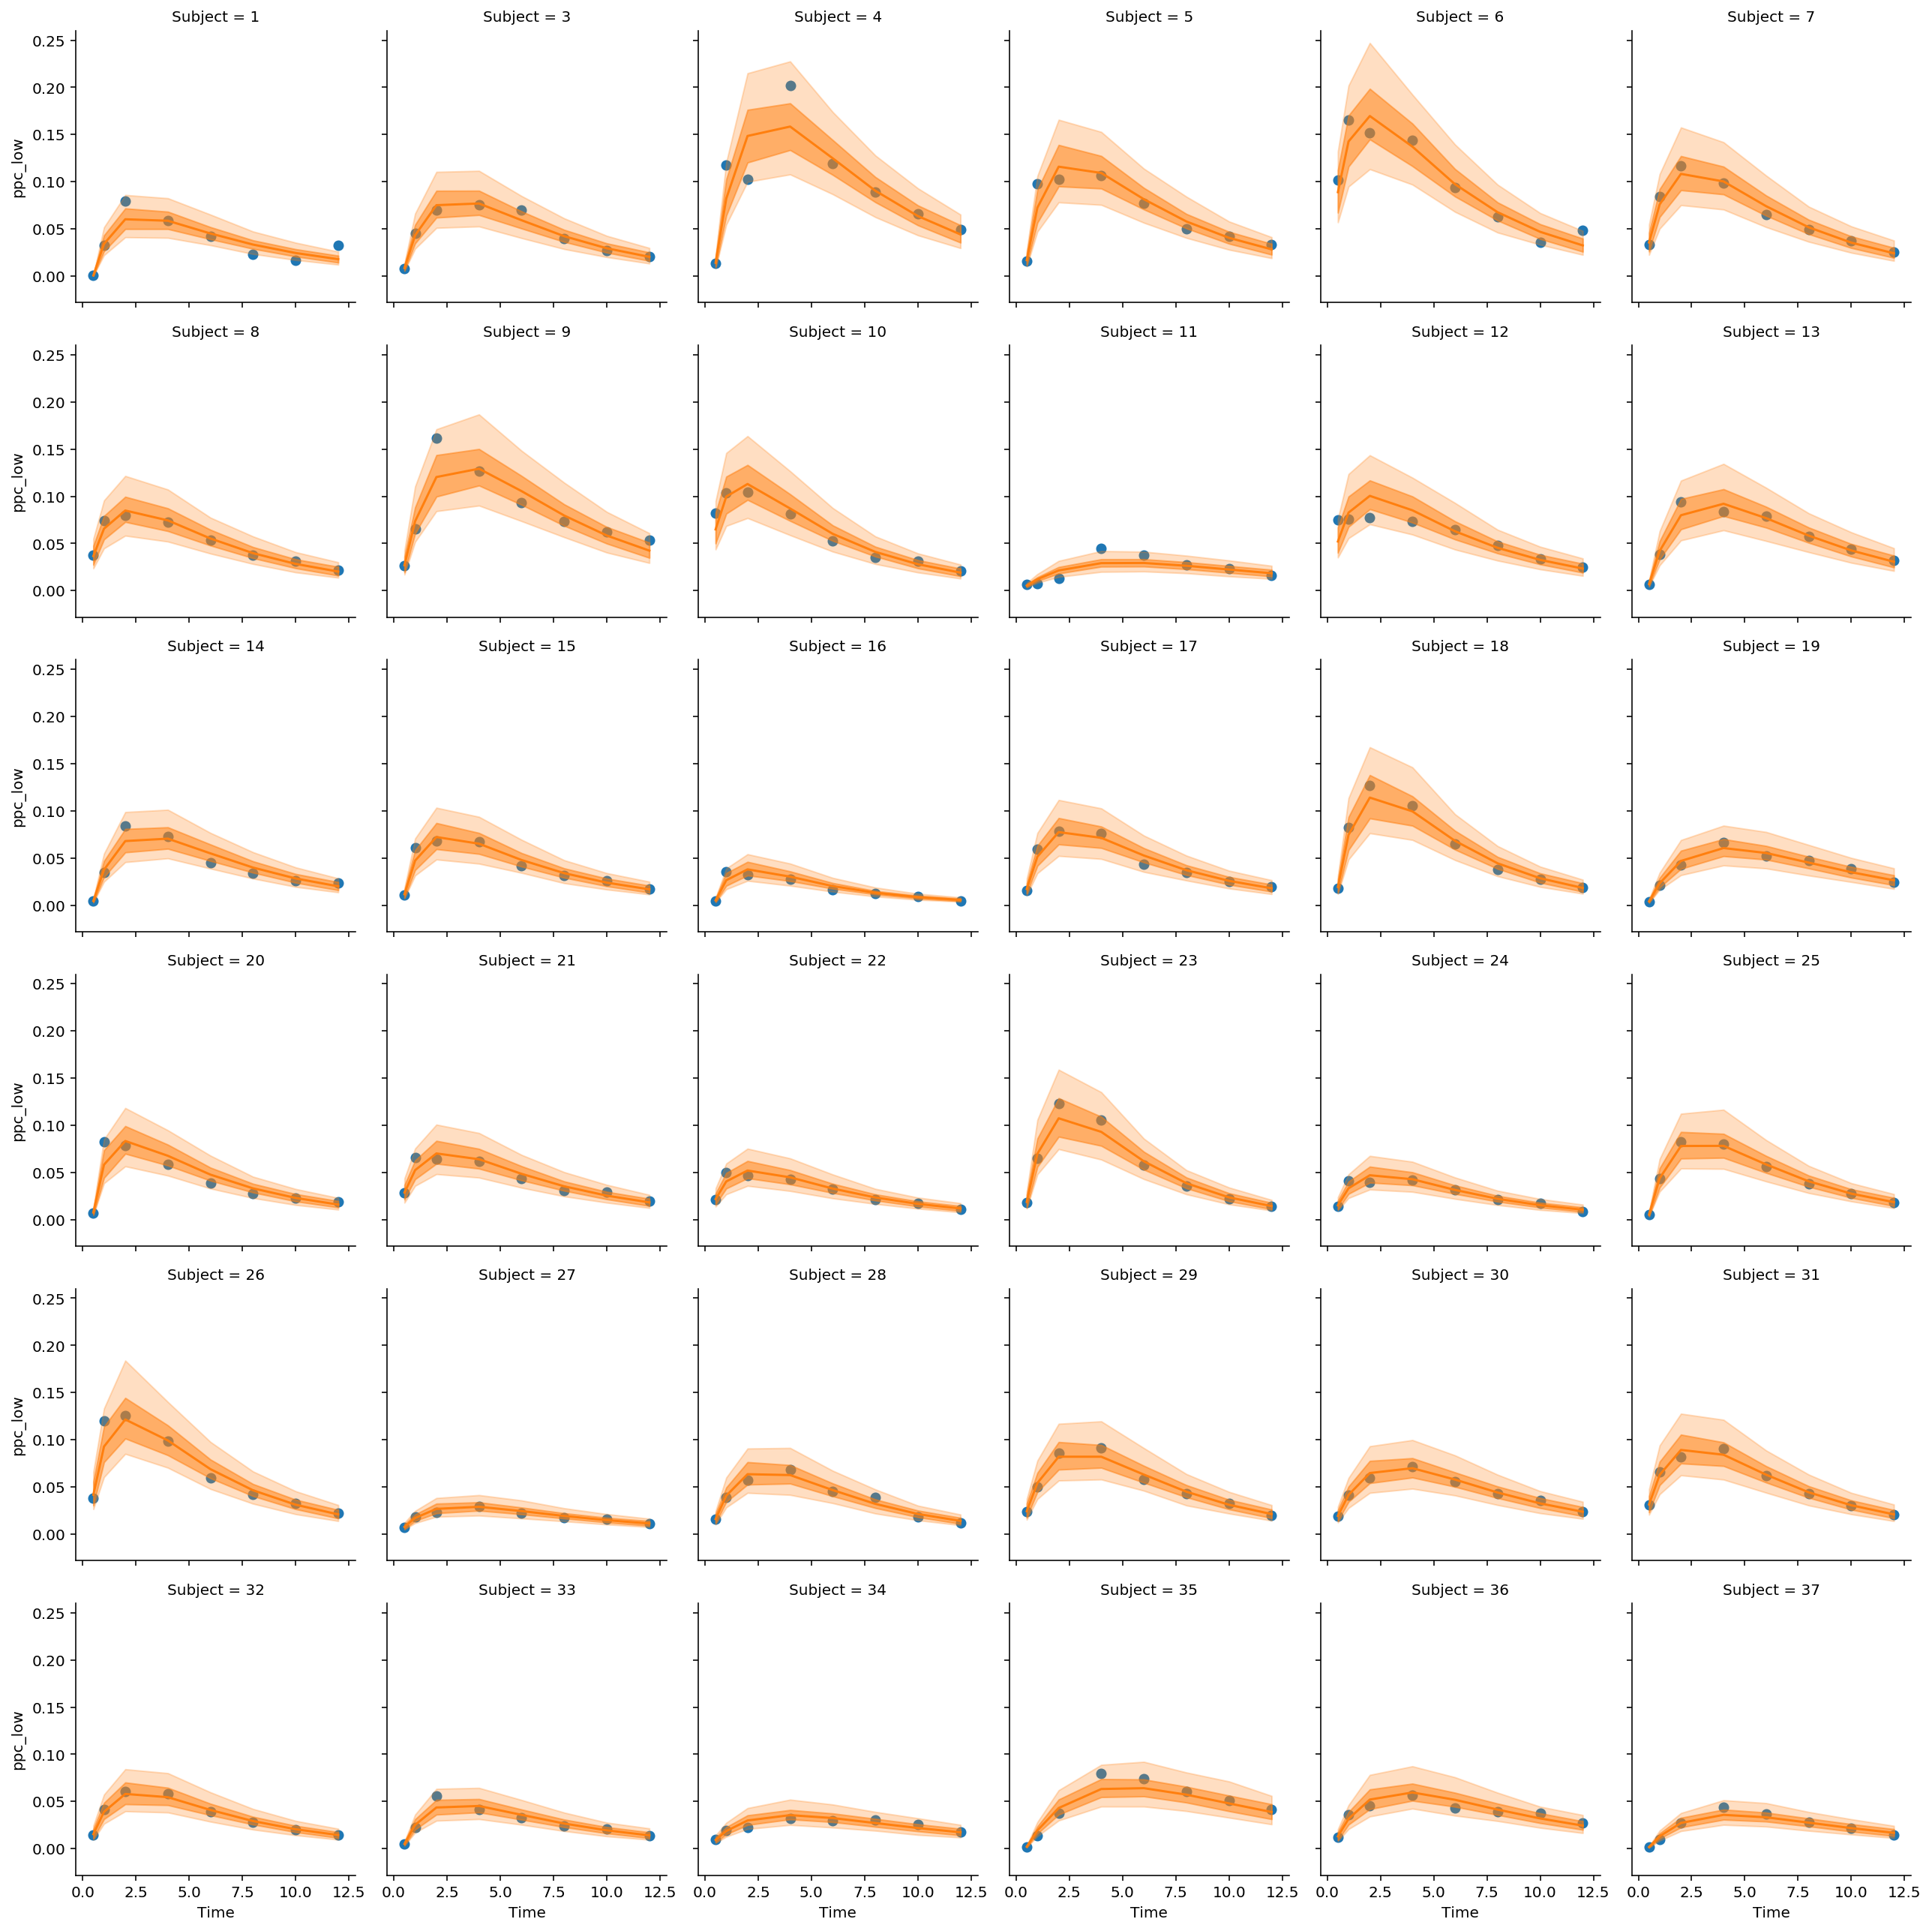

In [126]:
predictions = summarize_posterior(model_priors.posterior, 'y_est', 'pred')
ppc = summarize_ppc(model_priors.posterior_predictive,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

g = sns.FacetGrid(data = dfpred, col='Subject', col_wrap=6, sharey = True)
g.map(plt.scatter, 'Time','Concentration_scaled', color = 'C0')
g.map(plt.plot, 'Time','pred_pred', color = 'C1')
g.map(plt.fill_between,'Time','pred_low','pred_high',alpha = 0.5, color = 'C1')
g.map(plt.fill_between,'Time','ppc_low','ppc_high',alpha = 0.25, color = 'C1')

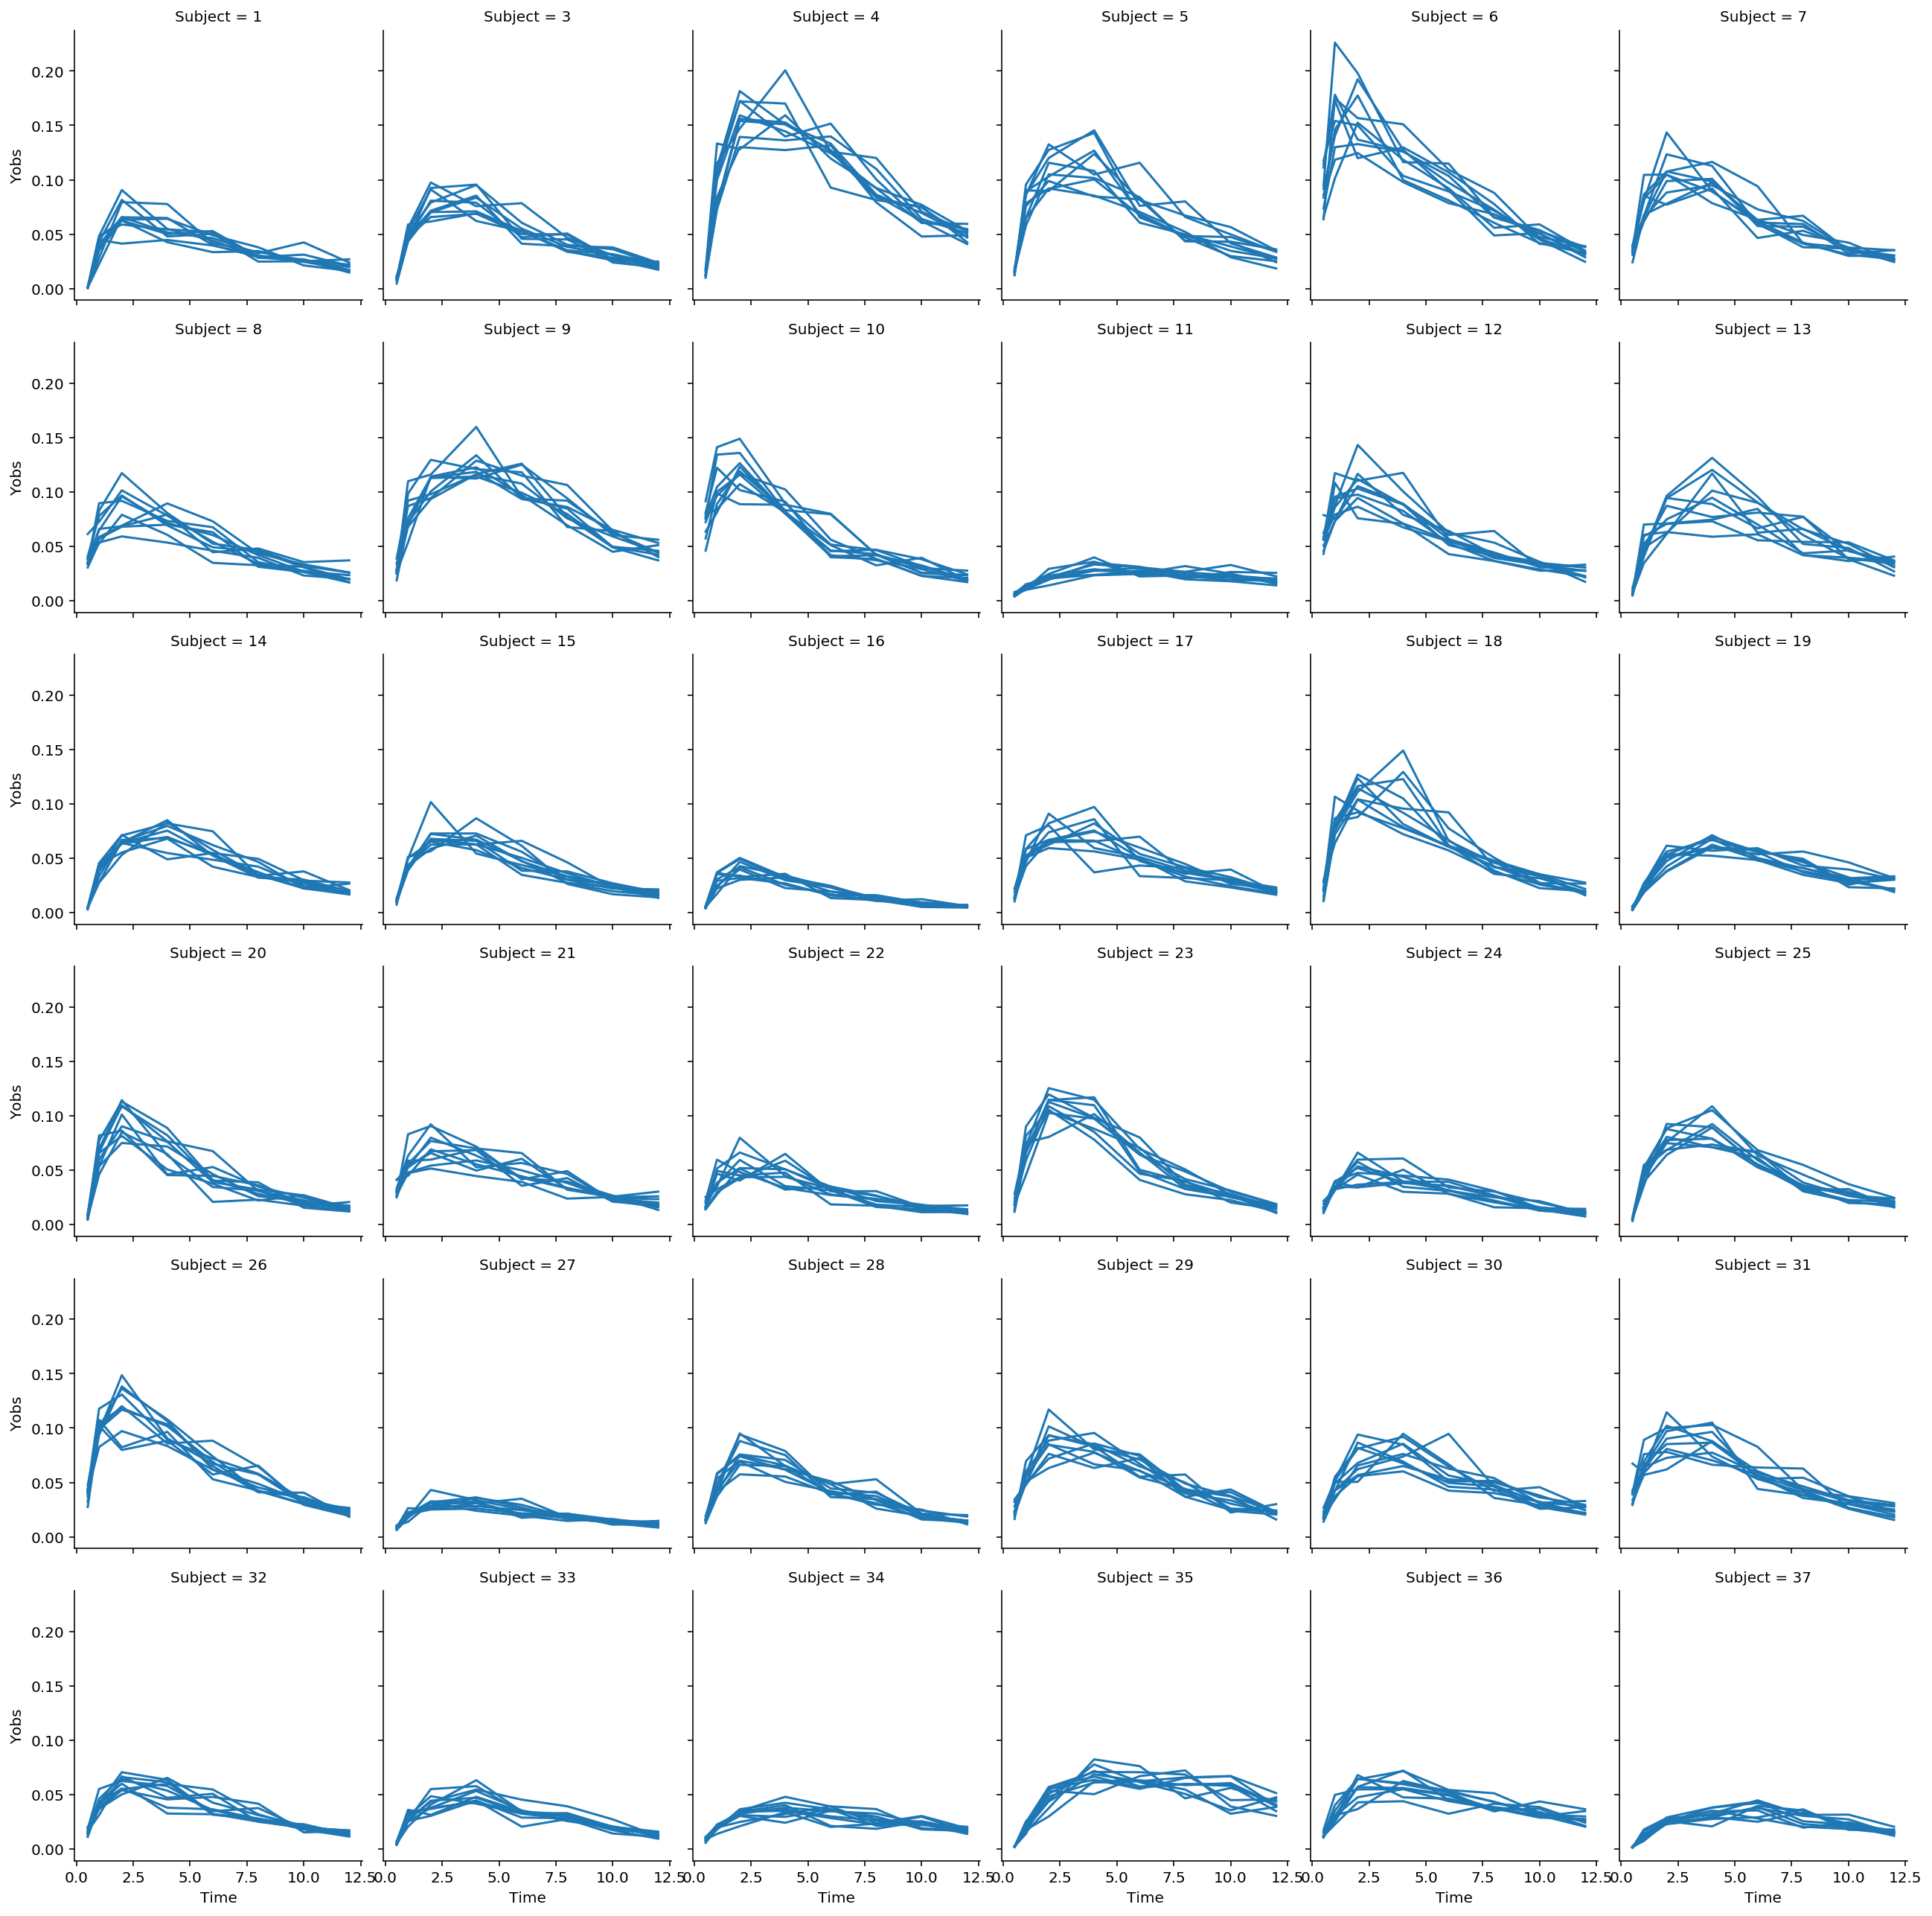

In [127]:
model_prior = model.posterior_predictive.Yobs.to_dataframe().query('draw<10 and chain==1')
dfsub = df.loc[:,['Time','Subject']]
replicates = pd.merge(dfsub, model_prior, left_index=True, right_on='Yobs_dim_0').reset_index('draw')

g = sns.FacetGrid(data = replicates, col='Subject', col_wrap=6, sharey = True)
g.map_dataframe(sns.lineplot,'Time','Yobs',estimator=None, units='draw')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c9c74ce10>,
      dtype=object)

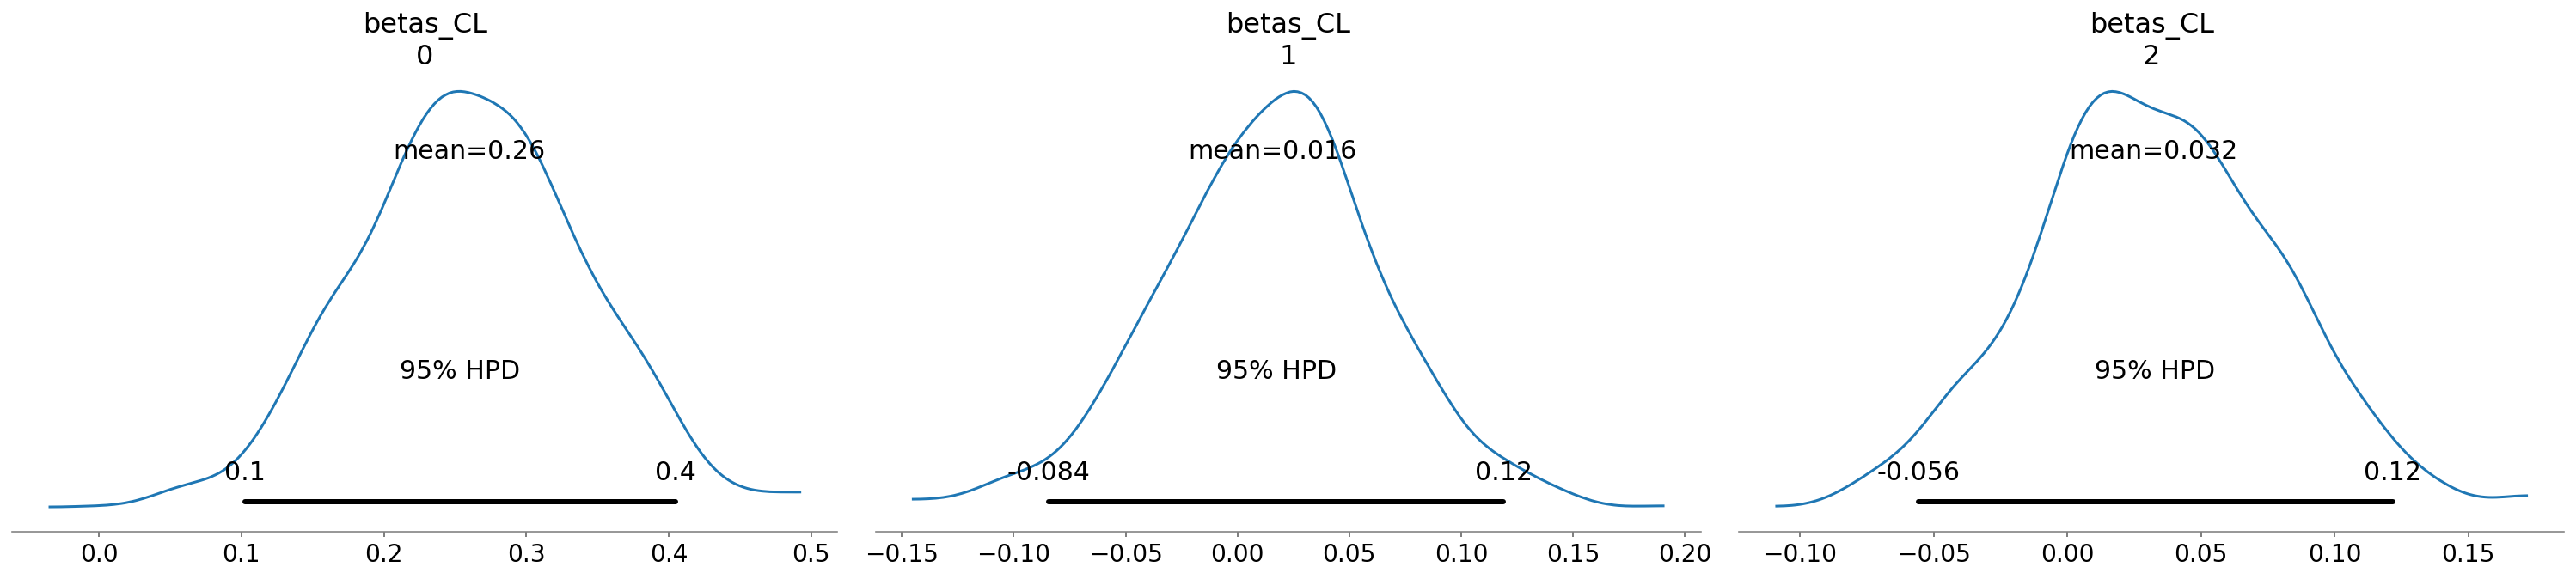

In [128]:
az.plot_posterior(model, var_names=['betas_CL'], credible_interval=0.95)

In [109]:
az.to_netcdf(model, 'data/rommel_experiment.net')

'data/rommel_experiment.net'

(array([ 21.,  65., 167., 242., 219., 159.,  80.,  31.,  12.,   4.]),
 array([0.10755725, 0.12997799, 0.15239873, 0.17481947, 0.19724021,
        0.21966095, 0.24208169, 0.26450243, 0.28692317, 0.30934391,
        0.33176465]),
 <a list of 10 Patch objects>)

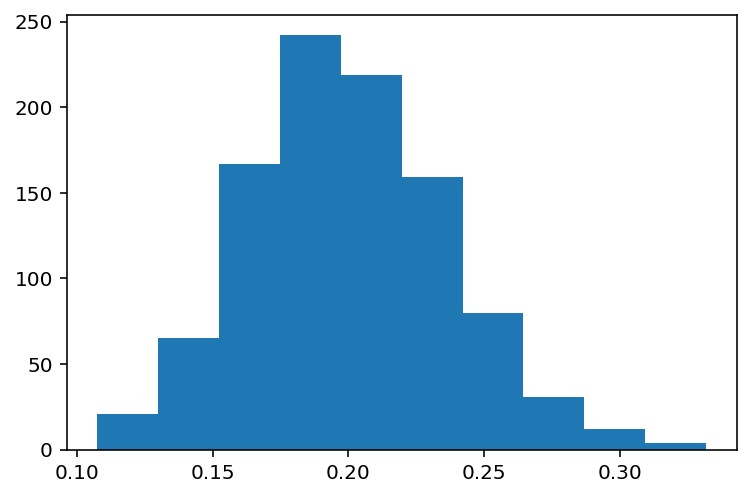

In [129]:
plt.hist(model.prior.alpha)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c96b15c50>],
      dtype=object)

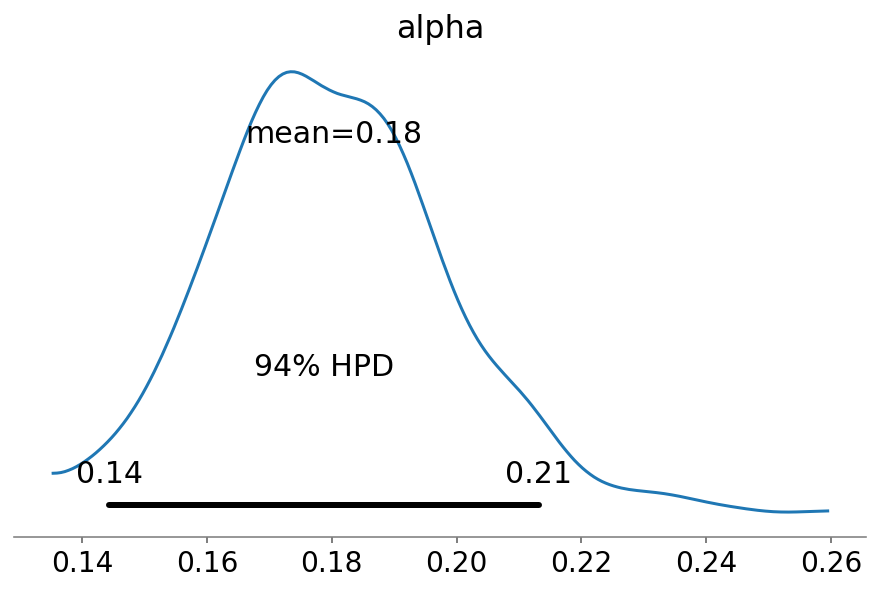

In [130]:
az.plot_posterior(model, var_names=['alpha'])